In [1]:
# Imports
from os import makedirs
from os.path import join
import pickle
import numpy as np
rng_seed = 399
np.random.seed(rng_seed)
from scipy.spatial.distance import pdist, cdist, squareform
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import sys
sys.path.append("..")

from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

from utils import get_model_checkpoint_filepaths

In [3]:
# Get last word embeddings from training
checkpoint_filepaths_dict = get_model_checkpoint_filepaths(
    output_dir="../output/word2vec_training/17-Oct-2020_01-00-56",
    model_name="word2vec",
    dataset_name="enwiki",
)
last_embedding_weights_filepath = checkpoint_filepaths_dict["intermediate_embedding_weight_filepaths"][-1]
last_embedding_weights = np.load(last_embedding_weights_filepath, mmap_mode="r").astype(np.float64)

In [4]:
# Implementation of the SD index
def sd_validity_index(X: np.ndarray, labels: np.ndarray) -> float:
    """Calculates the accuracy score using the SD index.

    Args:
        X: Datapoints to process
        labels: Labels for each datapoint in X

    Returns:
        score: Score computed using the SD index
    """
    unique_labels = np.unique(labels)
    scat = np.mean([np.linalg.norm(np.var(X[labels==lab], axis=0)) 
                    for lab in unique_labels]) / np.linalg.norm(np.var(X, axis=0))
    
    centers = np.array([np.mean(X[labels==lab], axis=0) for lab in unique_labels])
    center_dists = pdist(centers)
    dis = np.sum(1/np.sum(squareform(center_dists), axis = 0)) * np.max(center_dists) / np.min(center_dists)
    return scat + dis

# Implementation of the Dunn index
def dunn_index(X: np.ndarray, labels: np.ndarray) -> float:
    """Calculates the accuracy score using the Dunn index.

    Args:
        X: Datapoints to process
        labels: Labels for each datapoint in X

    Returns:
        score: Score computed using the Dunn index
    """
    unique_labels = np.unique(labels)
    diam = np.max([np.max(pdist(X[labels==lab])) for lab in unique_labels])
    sep = np.min([np.min(cdist(X[labels==unique_labels[i]], X[labels==unique_labels[j]])) 
                  for i in range(len(unique_labels)) for j in range(i)])
    return sep/diam

In [5]:
def cluster_hyperparameters_search(
    clusterers: list,
    clusterer_names: list,
    clusterer_hyperparam_grids: list,
    clusterer_metric: tuple,
    vocab_size: int,
    word_embeddings: np.ndarray,
    output_dir: str = None,
    model_name: str = None,
    dataset_name: str = None,
):
    """
    TODO: Docs
    """
    # Ensure output directory exists
    makedirs(output_dir, exist_ok=True)
    
    # Default to all words if -1
    if vocab_size == -1:
        vocab_size = len(word_embeddings)
    
    # Only fit on max `vocab_size` words.
    word_embeddings_fit = word_embeddings[:vocab_size]
    
    # Extract clusterer metric tuple
    clusterer_metric_name, clusterer_metric_func, clusterer_metric_opt_idx_func = clusterer_metric
    
    # Fit and predict cluster labels
    cluster_labels = {}
    for clusterer, clusterer_name, hyperparam_grid in zip(clusterers, clusterer_names, clusterer_hyperparam_grids):
        print(f"-- Fitting and predicting cluster labels using {clusterer_name} --")
        cluster_labels[clusterer_name] = {
            "labels": [],
            "metric_values": [],
            "best_labels_idx": -1
        }
        clusterer_metric_values = []
        for hyperparams in tqdm(hyperparam_grid):
            cls = clusterer(**hyperparams)
            cluster_labels_pred = cls.fit_predict(word_embeddings_fit)
            cluster_labels[clusterer_name]["labels"].append(cluster_labels_pred)
            try:
                cluster_metric_value = clusterer_metric_func(word_embeddings_fit, cluster_labels_pred)
            except:
                cluster_metric_value = np.nan
            clusterer_metric_values.append(cluster_metric_value)
        
        cluster_labels[clusterer_name]["metric_values"] = clusterer_metric_values
        best_cluster_labels_idx = clusterer_metric_opt_idx_func(clusterer_metric_values)
        cluster_labels[clusterer_name]["best_labels_idx"] = best_cluster_labels_idx
        
    
    # Save to output dir
    if output_dir is not None and model_name is not None and dataset_name is not None:
        output_path = join(output_dir, f"{model_name}-{dataset_name}-cluster_labels.pkl")
        with open(output_path, "wb") as file:
            pickle.dump(cluster_labels, file)
    
    return cluster_labels

In [6]:
# Define clusterers and hyperparameter grids
clusterers = [
    KMeans,
    GaussianMixture,
    # SpectralClustering,
    AgglomerativeClustering,
    HDBSCAN
]
clusterer_names = [
    "K-means clustering",
    "Gaussian mixture models",
    # "Spectral clustering",
    "Agglomerative clustering",
    "HDBSCAN"
]
max_cluster_num = 20
ks = list(range(3, max_cluster_num + 1))
clusterer_hyperparam_grids = [
    {"n_clusters": ks, "random_state": [rng_seed]},
    {"n_components": ks, "random_state": [rng_seed]},
    # {"n_clusters": ks, "random_state": [rng_seed]},
    {"n_clusters": ks, "linkage": ["ward", "complete", "average", "single"]},
    {
        "core_dist_n_jobs": [-1],
        "min_cluster_size": [2, 4, 8, 16, 32, 64, 128, 256], 
        "min_samples": [1, 2, 4, 8, 16, 32, 64, 128, 256]
    }
]
clusterer_hyperparam_grids = [ParameterGrid(params) for params in clusterer_hyperparam_grids]
vocab_size = 10000

In [6]:
pred_cluster_labels = cluster_hyperparameters_search(
    clusterers=clusterers,
    clusterer_names=clusterer_names,
    clusterer_hyperparam_grids=clusterer_hyperparam_grids,
    clusterer_metric=(
        "Average silhouette score",
        silhouette_score,
        np.nanargmax
    ),
    vocab_size=vocab_size,
    word_embeddings=last_embedding_weights,
    output_dir="../output/word2vec_cluster_analysis",
    model_name="word2vec",
    dataset_name="enwiki"
)

-- Fitting and predicting cluster labels using K-means clustering --



-- Fitting and predicting cluster labels using Gaussian mixture models --



-- Fitting and predicting cluster labels using Agglomerative clustering --



-- Fitting and predicting cluster labels using HDBSCAN --


In [10]:
load_pred_cluster_labels_from_file = True
if load_pred_cluster_labels_from_file:
    with open("../output/word2vec_cluster_analysis/word2vec-enwiki-cluster_labels.pkl", "rb") as file:
        pred_cluster_labels = pickle.load(file)

In [11]:
def visualize_cluster_hyperparameters_search(
    pred_cluster_labels: dict,
    clusterer_hyperparam_grids: list,
    clusterer_metric: tuple
):
    """
    TODO: Docs
    """
    clusterer_metric_name, clusterer_metric_func, clusterer_metric_opt_idx_func = clusterer_metric
    for (clusterer_name, clusterer_labels), hyperparam_grid in zip(pred_cluster_labels.items(), clusterer_hyperparam_grids):
        
        # Extract metric results
        best_labels_idx = clusterer_labels["best_labels_idx"]
        metric_values = clusterer_labels["metric_values"]
        
        # Plot the metric scores for each hyperparameter choice
        plt.figure(figsize=(10, 7))
        plt.title(clusterer_name)
        plt.xlabel("Parameter index")
        plt.ylabel(clusterer_metric_name)
        
        # Make xticks be equal to hyperparameters used
        hyperparameters_range = range(len(clusterer_labels["labels"]))
        hyperparam_grid_str = [str(params) for params in list(hyperparam_grid)]
        #plt.tick_params(axis='x', which='major', labelsize="small")
        plt.xticks(hyperparameters_range, hyperparam_grid_str, rotation=90, ha='left')
        
        plt.scatter(hyperparameters_range, metric_values)
        plt.plot(hyperparameters_range, metric_values)
        #plt.tight_layout()
        plt.show()
        
        print(f"Best hyperparameters for {clusterer_name}: {hyperparam_grid[best_labels_idx]}")

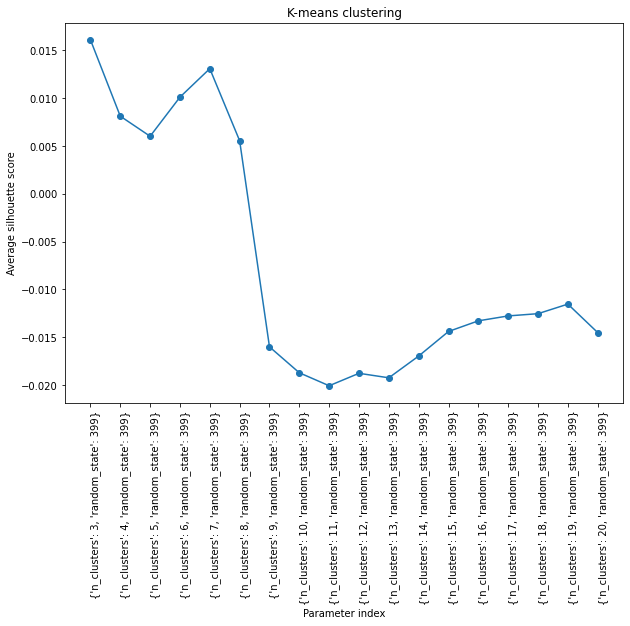

Best hyperparameters for K-means clustering: {'random_state': 399, 'n_clusters': 3}


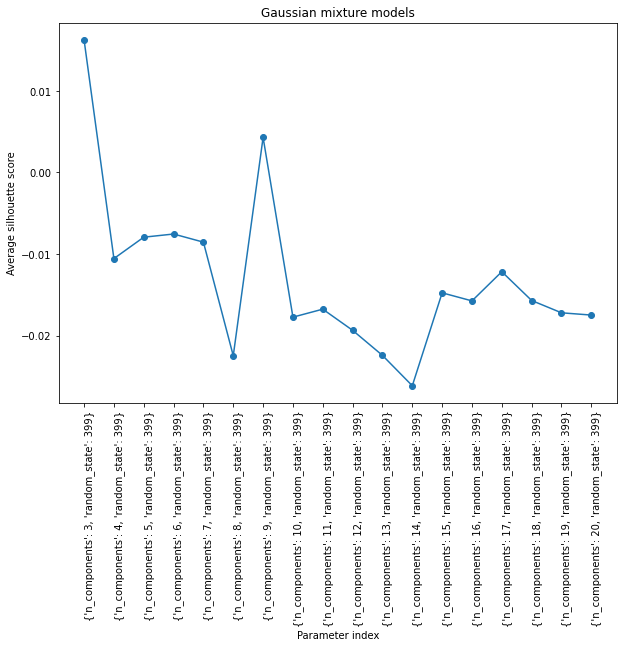

Best hyperparameters for Gaussian mixture models: {'random_state': 399, 'n_components': 3}


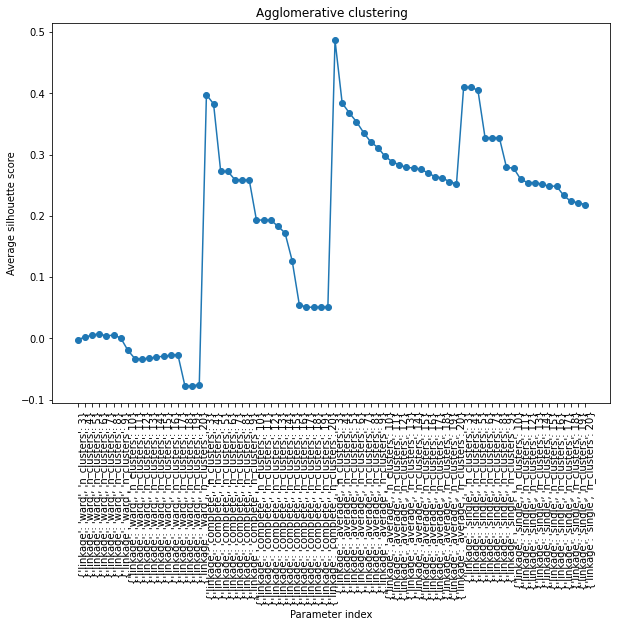

Best hyperparameters for Agglomerative clustering: {'n_clusters': 3, 'linkage': 'average'}


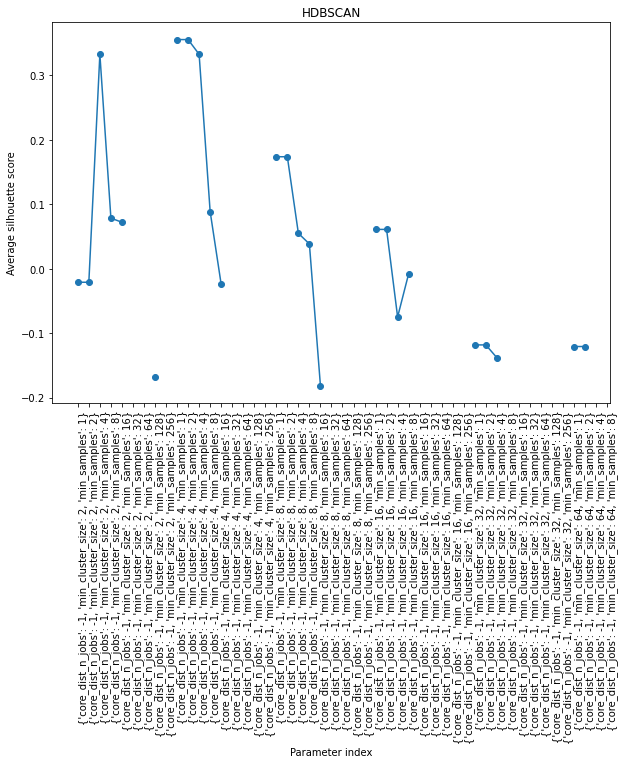

Best hyperparameters for HDBSCAN: {'min_samples': 1, 'min_cluster_size': 4, 'core_dist_n_jobs': -1}


In [12]:
visualize_cluster_hyperparameters_search(
    pred_cluster_labels=pred_cluster_labels,
    clusterer_hyperparam_grids=clusterer_hyperparam_grids,
    clusterer_metric=(
        "Average silhouette score",
        silhouette_score,
        np.nanargmax
    )
)

In [13]:
def evaluate_cluster_metrics(
    cluster_eval_metrics: list,
    pred_cluster_labels: dict,
    vocab_size: int,
    word_embeddings: np.ndarray,
):
    """
    TODO: Docs
    """
    # Default to all words if -1
    if vocab_size == -1:
        vocab_size = len(word_embeddings)
    
    # Only evaluate on max `vocab_size` words.
    word_embeddings_eval = word_embeddings[:vocab_size]
    
    metric_scores = {}
    for cluster_metric in cluster_eval_metrics:
        
        # Unpack metric tuple
        cluster_metric_name, cluster_metric_func, cluster_metric_opt_direction, cluster_metric_sort_func = cluster_metric
        print(f"-- {cluster_metric_name} --")
        
        num_clusterers = len(pred_cluster_labels)
        clusterers_range = range(num_clusterers)
        metric_scores[cluster_metric_name] = np.zeros(num_clusterers)
        for i, (clusterer_name, clusterer_labels) in zip(clusterers_range, pred_cluster_labels.items()):
            best_labels_idx = clusterer_labels["best_labels_idx"]
            best_labels = clusterer_labels["labels"][best_labels_idx]
            
            # Compute metric value
            metric_value = cluster_metric_func(word_embeddings_eval, best_labels)
            metric_scores[cluster_metric_name][i] = metric_value
            print(f"{clusterer_name}: {metric_value}")
        
        # Sort metric scores using metric sort function
        metric_sorted_indices = cluster_metric_sort_func(metric_scores[cluster_metric_name])
        metric_scores_sorted = metric_scores[cluster_metric_name][metric_sorted_indices]
        clusterer_names_sorted = np.array(list(pred_cluster_labels.keys()))[metric_sorted_indices]
        
        plt.title(f"{cluster_metric_name} ({cluster_metric_opt_direction} is better)")
        plt.ylabel(cluster_metric_name)
        plt.xticks(clusterers_range, clusterer_names_sorted, rotation=45)
        plt.scatter(clusterers_range, metric_scores_sorted)
        plt.plot(clusterers_range, metric_scores_sorted)
        plt.show()

In [14]:
sort_asc = lambda scores: np.argsort(scores)
sort_desc = lambda scores: np.argsort(scores)[::-1]
cluster_eval_metrics = [
    ("Davies-Bouldin score", davies_bouldin_score, "lower", sort_asc),
    # ("Dunn index", dunn_index, "higher", sort_desc),
    ("SD validity index", sd_validity_index, "lower", sort_asc)
]

-- Davies-Bouldin score --
K-means clustering: 6.382936563138251
Gaussian mixture models: 6.868518107495011
Agglomerative clustering: 0.37857307527293377
HDBSCAN: 2.446143819196456


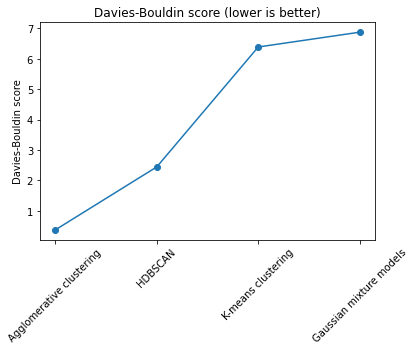

-- SD validity index --
K-means clustering: 2.3490703488940428
Gaussian mixture models: 2.5098433268445204
Agglomerative clustering: 0.5241425232850517
HDBSCAN: 2.275044554860071


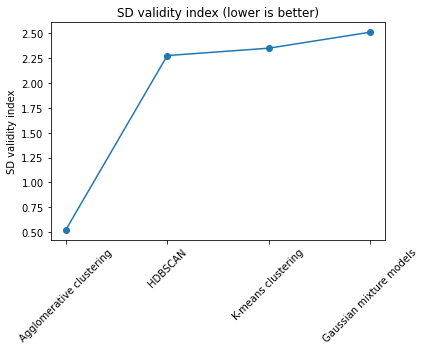

In [15]:
evaluate_cluster_metrics(
    cluster_eval_metrics=cluster_eval_metrics,
    pred_cluster_labels=pred_cluster_labels,
    vocab_size=vocab_size,
    word_embeddings=last_embedding_weights,
)

In [16]:
# Plot PCA variances
from sklearn.decomposition import PCA
last_embedding_weights_pca = PCA()
last_embedding_weights_pca.fit(last_embedding_weights[:vocab_size])

PCA()

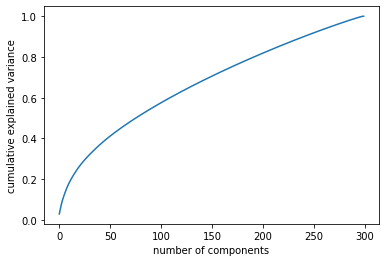

In [17]:
pca_cumsum = np.cumsum(last_embedding_weights_pca.explained_variance_ratio_)
plt.plot(pca_cumsum)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [18]:
np.where(pca_cumsum >= 0.9)[0][0]

241

In [19]:
import umap
last_embedding_weights_2d = umap.UMAP().fit_transform(last_embedding_weights[:vocab_size])

In [34]:
best_clusterer_name = "K-means clustering"
labels = pred_cluster_labels[best_clusterer_name]["labels"][pred_cluster_labels[best_clusterer_name]["best_labels_idx"]]

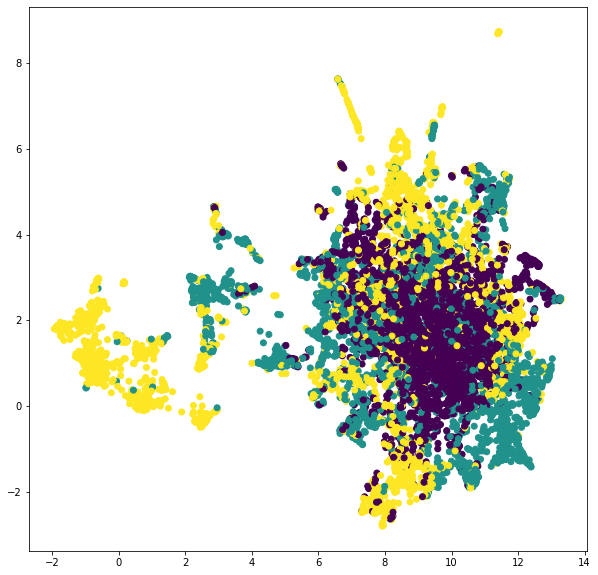

In [35]:
plt.figure(figsize=(10, 10))
plt.scatter(
    x=last_embedding_weights_2d[:, 0],
    y=last_embedding_weights_2d[:, 1],
    c=labels
)
plt.show()

In [4]:
def evaluate_cluster_methods(
    word_embeddings: np.ndarray,
    vocab_size: int,
    cluster_classes: list,
    cluster_metrics: list,
    cluster_numbers: list,
) -> dict:
    """
    TODO: Docs
    """
    X = word_embeddings[:vocab_size]
    clusterer_results = {clusterer_name: {} for clusterer_name, _, _ in cluster_classes}
    for cluster_name, cluster_cls, kwargs in cluster_classes:
        print(f"--- Evaluating {cluster_name}... ---")
        if cluster_name != "HDBSCAN":
            clusterer_results[cluster_name] = {
                "labels": {},
                "metric_scores": {metric_name: [] for metric_name, _, _ in cluster_metrics},
                "optimal_metric_score_indices": {}
            }
            for k in tqdm(ks, desc="Fitting and predicting"):
                cls = cluster_cls(n_clusters=k, **kwargs)
                cluster_labels = cls.fit_predict(X)
                clusterer_results[cluster_name]["labels"][k] = cluster_labels
                
                for metric_name, metric_func, _ in cluster_metrics:
                    metric_score = metric_func(X, cluster_labels)
                    clusterer_results[cluster_name]["metric_scores"][metric_name].append(metric_score)
                
                for metric_name, _, metric_opt_value_idx_func in cluster_metrics:
                    opt_value_idx = metric_opt_value_idx_func(
                        clusterer_results[cluster_name]["metric_scores"][metric_name]
                    )
                    clusterer_results[cluster_name]["optimal_metric_score_indices"][metric_name] = opt_value_idx
        else:
            cls = cluster_cls()
            cluster_labels = cls.fit_predict(X)
            clusterer_results[cluster_name] = {
                "labels": cluster_labels,
                "metric_scores": {metric_name: [] for metric_name, _, _ in cluster_metrics},
                "optimal_metric_score_indices": {}
            }
            
            for metric_name, metric_func, _ in cluster_metrics:
                metric_score = metric_func(X, cluster_labels)
                print(f"- {metric_name}: {metric_score:.3f}")
                clusterer_results[cluster_name]["metric_scores"][metric_name].append(metric_score)
            
            for metric_name, _, metric_opt_value_idx_func in cluster_metrics:
                opt_value_idx = metric_opt_value_idx_func(
                    clusterer_results[cluster_name]["metric_scores"][metric_name]
                )
                clusterer_results[cluster_name]["optimal_metric_score_indices"][metric_name] = opt_value_idx
    return clusterer_results

In [5]:
cluster_classes = [
    ("K-means clustering", KMeans, {}),
    # ("Spectral clustering", SpectralClustering, {"n_jobs": -1}),
    ("Agglomerative clustering", AgglomerativeClustering, {}),
    ("HDBSCAN", HDBSCAN, {"core_dist_n_jobs": -1})
]
cluster_metrics = [
    ("Average silhouette score", silhouette_score, np.argmax),
    ("Davies-Bouldin score", davies_bouldin_score, np.argmin),
    ("Dunn index", dunn_index, np.argmax),
    ("SD validity index", sd_validity_index, np.argmin)
]
max_cluster_num = 250
ks = list(range(3, max_cluster_num + 1))

In [ ]:
# Perform evaluation
cluster_results_dict = evaluate_cluster_methods(
    word_embeddings=last_embedding_weights,
    vocab_size=30000,
    cluster_classes=cluster_classes,
    cluster_metrics=cluster_metrics,
    cluster_numbers=ks
)

--- Evaluating HDBSCAN... ---


In [ ]:
def visualize_cluster_results(cluster_results: dict) -> None:
    """
    TODO: Docs
    """
    for cluster_name, cluster_content in cluster_results_dict.items():
        metric_names = list(cluster_content["metric_scores"].keys())
        
        if cluster_name != "HDBSCAN":
            print(f"-- Visualizing metrics for {cluster_name} --")
            ks = list(cluster_content["labels"].keys())
            fig, axes = plt.subplots(nrows=1, ncols=len(metric_names), figsize=(3.25 * len(metric_names), 3))
            for metric_name, ax in zip(metric_names, axes.ravel()):
                metric_scores = cluster_content["metric_scores"][metric_name]
                optimal_metric_score_idx = cluster_content["optimal_metric_score_indices"][metric_name]
                ax.set_title(metric_name)
                ax.set_xlabel("Cluster number")
                ax.set_ylabel("Metric value")
                ax.scatter(ks, metric_scores)
                ax.plot(ks, metric_scores)
                ax.plot(ks[optimal_metric_score_idx], metric_scores[optimal_metric_score_idx], 'ro')
            plt.tight_layout()
            plt.show()
        else:
            print(f"-- Printing metrics for {cluster_name} --")
            for metric_name in metric_names:
                metric_value = cluster_content["metric_scores"][metric_name][0]
                print(f"{metric_name}: {metric_value}")

In [ ]:
visualize_cluster_results(cluster_results_dict)

In [ ]:
# TODO: Synonym words should be in the same cluster.